In [ ]:
# standard data science packages
import pandas as pd
import numpy as np

# data viz imports
import matplotlib.pyplot as plt
import folium
import seaborn as sns

# file system imports
import os

# sklearn imports
from sklearn.model_selection import train_test_split

In [ ]:
# set parameters
dataset = "361260"
seeds = range(5)
clustertype = "kmeans"
clustermodel = "linear"

In [ ]:
### READ IN DATA ###
base_path = f'../cluster-results/{clustertype}/{clustermodel}'
color_map = {
    'elastic_norank': 'black',
    'lime': '#71BEB7',
    'shap': 'orange',
    'lmdi_baseline': '#9B5DFF',
    'random': 'gray',
    'global_elastic_norank': 'red'
}
methods_name = {
    'elastic_norank': 'LMDI+',
    'lmdi_baseline': 'LMDI',
    'lime': 'LIME',
    'shap': 'TreeSHAP',
    'random': 'Random',
    'global_elastic_norank': 'Global'
}

seed_means = []
seed_sds = []

# go through each of the subdirectories and read data
for seed in seeds:
    
    # check that the directory exists
    if not os.path.exists(base_path + f'/{dataset}/seed{seed}'):
        print(f"Directory {base_path}/{dataset}/seed{seed} does not exist")
        continue

    # get the data (removing the 'unnamed' column)
    mse_means = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_mean.csv').iloc[:,1:]
    mse_sds = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_sd.csv').iloc[:,1:]
    
    # convert sds to ses by dividing by sqrt(n)
    mse_sds = mse_sds / np.sqrt(100)
    
    # get the methods we care about
    methods = ["elastic_norank",
               'lmdi_baseline', 'lime', 'shap',
               "global_elastic_norank", "random"]
    all_methods = []
    for method in methods:
        all_methods.append(method)
        
    # get the data for the methods we care about
    mse_means = mse_means[all_methods]
    mse_sds = mse_sds[all_methods]
    
    # append the data to the list
    seed_means.append(mse_means)
    seed_sds.append(mse_sds)
# take the average of the dataframes in the list
mean_df = pd.concat(seed_means).groupby(level=0).mean()
sd_df = pd.concat(seed_sds).groupby(level=0).mean()

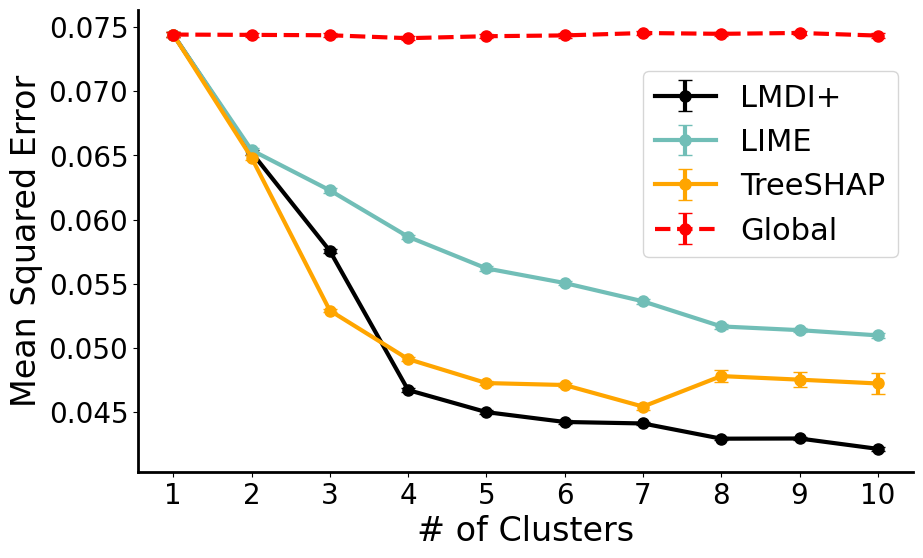

In [ ]:
### PLOT CLUSTERING RESULTS ###
# The x-axis values
x_values = np.array(range(1, 11), dtype = int)

# create the plot
plt.figure(figsize=(10, 6))
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0
# take off top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plot each column as a separate line with error bars
for col in mean_df.columns:
    if methods_name[col] in ['Random', 'LMDI'] :
        continue
    if methods_name[col] == "Global":
        linestyle = "dashed"
    else:
        linestyle = "solid"
    plt.errorbar(x_values, mean_df[col], yerr=sd_df[col],
                 label=methods_name[col], color=color_map[col],
                capsize=5, fmt='o', linestyle=linestyle, linewidth=3, markersize=8)

# adding labels and title
plt.xlabel("# of Clusters", fontsize=24)
plt.ylabel("Mean Squared Error", fontsize=24)

# only put x-axis ticks on integers
plt.xticks(x_values)
# make x tick labels larger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# locate legend on right with y = 0.07

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=22)

# plt.savefig("images/subgroup_error.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [5]:
# read in the miami housing dataset
X_miami = np.loadtxt("../data_openml/X_361260.csv", delimiter=",")[1:,:]
y_miami = np.loadtxt("../data_openml/y_361260.csv", delimiter=",")[1:]
cols_miami = ['LATITUDE', 'LONGITUDE', 'LND_SQFOOT', 'TOT_LVG_AREA',
              'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST',
              'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age', 'avno60plus',
              'month_sold', 'structure_quality']

# read in shap values
shap_miami = np.loadtxt("../lfi-values/seed0/361260/shap.csv",
                        delimiter=",")

# read in lotla values
lmdi_plus_miami = np.loadtxt("../lfi-values/seed0/361260/" + \
    "elastic_norank.csv", delimiter=",")

# split into train and test 50/50 with seed 0
_, X_miami, _, y_miami = train_test_split(X_miami, y_miami,
                                          test_size = 0.5, random_state = 0)

# read in cluster labels
base = f"../cluster-results/kmeans/{clustermodel}/361260/seed0/"
labels_shap = np.loadtxt(base + "k4_shap_labels.csv", delimiter=",")
labels_lmdi_plus = np.loadtxt(base + \
    "k4_elastic_norank_labels.csv", delimiter=",")

In [6]:
# get average feature values per cluster for lotla
lmdi_plus_clusters = pd.DataFrame(X_miami, columns = cols_miami)
lmdi_plus_clusters['cluster'] = labels_lmdi_plus

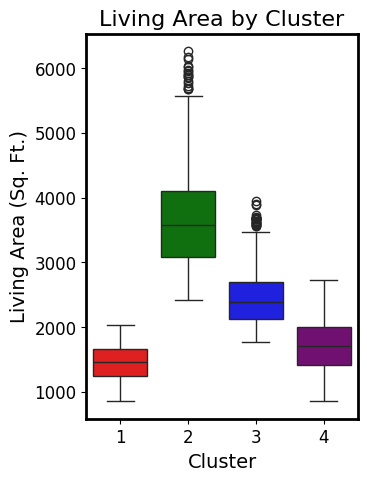

In [7]:
# make boxplot of living area
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
plt.figure(figsize = (3.5, 5))
colors = [color_map[cluster] for cluster in range(4)]
bp = sns.boxplot(x = 'cluster', y = 'TOT_LVG_AREA', data = lmdi_plus_clusters, palette=colors, hue='cluster')
# make colors of the boxes match the density plot
plt.title("Living Area by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Living Area (Sq. Ft.)", fontsize=14)
# plt.savefig("images/sqft.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_1810979/275088998.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x = lmdi_plus_clusters['cluster'], y = y_miami, palette=colors)


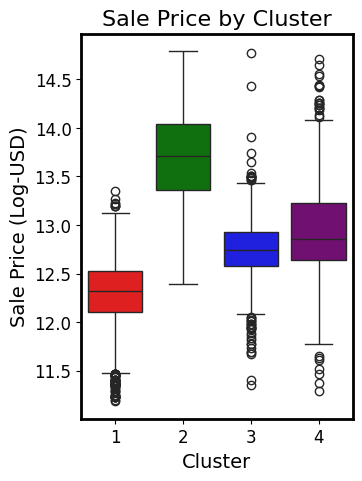

In [8]:
# make boxplot of sale price
plt.figure(figsize = (3.5, 5))
colors = [color_map[cluster] for cluster in range(4)]
bp = sns.boxplot(x = lmdi_plus_clusters['cluster'], y = y_miami, palette=colors)
# make colors of the boxes match the density plot
plt.title("Sale Price by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Sale Price (Log-USD)", fontsize=14)
# plt.savefig("images/price.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [9]:
### MAKE MAP ###

color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(lmdi_plus_clusters.iloc[:, 0], lmdi_plus_clusters.iloc[:, 1], lmdi_plus_clusters.loc[:, 'cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
# add legend to map with colors
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 110px; height: 85px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 1.0;">
     &nbsp; Cluster #1 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
     &nbsp; Cluster #2 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
     &nbsp; Cluster #3 &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
     &nbsp; Cluster #4 &nbsp; <i class="fa fa-circle" style="color:purple"></i>
</div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
m
# save the map to an HTML file
# m.save("images/miami_clusters.html")